In [1]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,389 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.5 kB]
Get:13 http://archi

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in real_estate_sales.csv data from the S3 Bucket realestateproj
from pyspark import SparkFiles
url ="https://creditcardeligibility.s3.ap-southeast-2.amazonaws.com/dataset.csv"
spark.sparkContext.addFile(url)

credit_card_eligibility = spark.read.csv(SparkFiles.get("dataset.csv"), header=True, inferSchema=True)

credit_card_eligibility.show(2)

+-------+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+-----------------+------------------+-----------+--------------------+--------------+-----------------+---------------+------+
|     ID|Gender|Own_car|Own_property|Work_phone|Phone|Email|Unemployed|Num_children|Num_family|Account_length|Total_income|              Age|    Years_employed|Income_type|      Education_type| Family_status|     Housing_type|Occupation_type|Target|
+-------+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+-----------------+------------------+-----------+--------------------+--------------+-----------------+---------------+------+
|5008804|     1|      1|           1|         1|    0|    0|         0|           0|         2|            15|    427500.0|32.86857361889703|12.435573625741801|    Working|    Higher education|Civil marriage| Rented apartment|          Other|     1|


In [4]:
# Import the required modules
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from scipy.stats.mstats import winsorize
from pyspark.ml.feature import VectorAssembler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
# Convert dataframe to pandas
df_creditcard = credit_card_eligibility.toPandas()

In [6]:
# Check the DataFrame
df_creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int32  
 1   Gender           9709 non-null   int32  
 2   Own_car          9709 non-null   int32  
 3   Own_property     9709 non-null   int32  
 4   Work_phone       9709 non-null   int32  
 5   Phone            9709 non-null   int32  
 6   Email            9709 non-null   int32  
 7   Unemployed       9709 non-null   int32  
 8   Num_children     9709 non-null   int32  
 9   Num_family       9709 non-null   int32  
 10  Account_length   9709 non-null   int32  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [7]:
# Generate dummies for the categorical features and drop the non_feature column "ID"
modelling_df = pd.get_dummies(df_creditcard, dtype=int)
modelling_df = modelling_df.drop(columns="ID")
modelling_df.head(2)

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
0,1,1,1,1,0,0,0,0,2,15,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,2,29,...,0,0,0,0,0,0,0,0,1,0


In [8]:
# Check the modelling DataFrame
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Gender                                        9709 non-null   int32  
 1   Own_car                                       9709 non-null   int32  
 2   Own_property                                  9709 non-null   int32  
 3   Work_phone                                    9709 non-null   int32  
 4   Phone                                         9709 non-null   int32  
 5   Email                                         9709 non-null   int32  
 6   Unemployed                                    9709 non-null   int32  
 7   Num_children                                  9709 non-null   int32  
 8   Num_family                                    9709 non-null   int32  
 9   Account_length                                9709 non-null   i

In [9]:
# Make a copy of the DataFrame modelling_df and split the features
X = modelling_df.copy()
X.drop("Target", axis=1, inplace=True)
# Check the features
X.head(2)

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
0,1,1,1,1,0,0,0,0,2,15,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,2,29,...,0,0,0,0,0,0,0,0,1,0


In [10]:
# Get and check the target
y=modelling_df["Target"].ravel()
y[:2]

array([1, 0], dtype=int32)

In [11]:
# Splitting the data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [12]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [13]:
# Fit the scaler on the training data
X_scaler = scaler.fit(X_train)

In [14]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Fitting the Random Forest Model

In [15]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [16]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [17]:
 # Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [18]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [19]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2078,2
Actual 1,347,1


Accuracy Score : 0.8562602965403624
Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2080
           1       0.33      0.00      0.01       348

    accuracy                           0.86      2428
   macro avg       0.60      0.50      0.46      2428
weighted avg       0.78      0.86      0.79      2428



Feature Importance

In [20]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
important_features = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
important_features[:20]

[(0.1719755401090585, 'Age'),
 (0.14316837984422426, 'Account_length'),
 (0.12680737265147168, 'Years_employed'),
 (0.12534694991263326, 'Total_income'),
 (0.03172016023869808, 'Num_family'),
 (0.022972874410537615, 'Num_children'),
 (0.02284912140715757, 'Own_car'),
 (0.02180895776813514, 'Phone'),
 (0.02171162316004561, 'Own_property'),
 (0.02042271581256511, 'Gender'),
 (0.01725835493840302, 'Work_phone'),
 (0.015760844958158094, 'Income_type_Working'),
 (0.014864222204069083, 'Education_type_Secondary / secondary special'),
 (0.014575467818451359, 'Family_status_Married'),
 (0.01442705407221932, 'Income_type_Commercial associate'),
 (0.013797068150789975, 'Education_type_Higher education'),
 (0.012939985111652225, 'Occupation_type_Laborers'),
 (0.012627658564639124, 'Occupation_type_Other'),
 (0.012092294712475473, 'Email'),
 (0.011458985165218455, 'Family_status_Single / not married')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

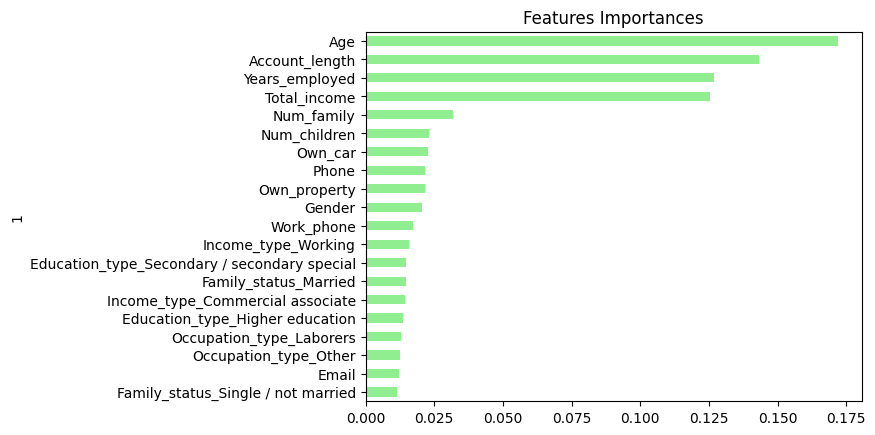

In [21]:
# Visualize the features by importance
importances_df = pd.DataFrame(important_features[:20])
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

**Findings from the random forest model**: Given all the available features in the dataset, the random forest model could produce a reasonable accuracy rate (at 85.6%) to predict individuals' eligibility for a credit card. The most important features considered are Age, Account_length, Years_employed, and total_income.

**Optimise the Model**

In [22]:
# winsorize the continuous features
modelling_df["Age_w"]= winsorize(modelling_df["Age"], limits=(0.05, 0.95))
modelling_df["Account_length_w"]= winsorize(modelling_df["Account_length"], limits=(0.05, 0.95))
modelling_df["Years_employed_w"]= winsorize(modelling_df["Years_employed"], limits=(0.05, 0.95))
modelling_df["Total_income_w"]= winsorize(modelling_df["Total_income"], limits=(0.05, 0.95))
modelling_df["Num_family_w"]= winsorize(modelling_df["Num_family"], limits=(0.05, 0.95))
modelling_df["Num_children_w"]= winsorize(modelling_df["Num_children"], limits=(0.05, 0.95))
modelling_df.head(2)

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,...,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff,Age_w,Account_length_w,Years_employed_w,Total_income_w,Num_family_w,Num_children_w
0,1,1,1,1,0,0,0,0,2,15,...,0,0,0,0,26.593291,3,0.0,67500.0,1,0
1,1,1,1,0,0,0,0,0,2,29,...,0,0,1,0,26.593291,3,0.0,67500.0,1,0


In [23]:
# Re_split our preprocessed data into our features and target arrays
y = modelling_df["Target"]
# keep the most important features including the winsorised columns
X = modelling_df[["Age_w", "Account_length_w", "Years_employed_w", "Total_income_w",
                 "Num_family_w", "Num_children_w", "Own_car", "Phone", "Own_property",
                 "Gender", "Work_phone", "Income_type_Working", "Education_type_Secondary / secondary special",
                  "Family_status_Married", "Income_type_Commercial associate", "Education_type_Higher education",
                  "Occupation_type_Laborers","Occupation_type_Other","Email"
                 ]]
X.head(2)

,Age_w,Account_length_w,Years_employed_w,Total_income_w,Num_family_w,Num_children_w,Own_car,Phone,Own_property,Gender,Work_phone,Income_type_Working,Education_type_Secondary / secondary special,Family_status_Married,Income_type_Commercial associate,Education_type_Higher education,Occupation_type_Laborers,Occupation_type_Other,Email
0,26.593291,3,0.0,67500.0,1,0,1,0,1,1,1,1,0,0,0,1,0,1,0
1,26.593291,3,0.0,67500.0,1,0,1,0,1,1,0,1,1,1,0,0,0,0,0


In [24]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [25]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Create a function for neural network models
def create_and_run_nn_model(input_shape, layers_config,
optimizer='adam',
loss = 'binary_crossentropy',
metrics = ['accuracy'],
X_train_scaled=None, y_train = None,
X_test_scaled=None, y_test = None,
epochs=20, batch_size=32):

  nn_model = Sequential() # initialise the model
  nn_model.add(Dense(units=layers_config[0]['units'],
                     activation=layers_config[0]['activation'],
                     input_dim=X_train_scaled.shape[1])) # add the input layer
  for layer in layers_config[1:]: # loop through the remaining layers
    nn_model.add(Dense(units=layer['units'],
                       activation=layer['activation'])) # add the hidden layers
    nn_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # compile the model
    history = nn_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test)) # train the models
    evaluation = nn_model.evaluate(X_test_scaled, y_test, batch_size=batch_size) # evaluate the models
  return nn_model, history, evaluation


In [29]:
# Test model 1
layers_config = [{'units': 20, 'activation':'relu'}, {'units':1, 'activation':'sigmoid'}]
nn_model, history, evaluation = create_and_run_nn_model(X_train_scaled.shape[1],layers_config, optimizer='adam', metrics=['accuracy'],
                                                        X_train_scaled=X_train_scaled, y_train=y_train,
                                                        X_test_scaled=X_test_scaled, y_test=y_test,
                                                        epochs=50, batch_size=32)
print("Evaluation Results: ", evaluation)

Epoch 1/50
228/228 [==============================] - 5s 10ms/step - loss: 0.4583 - accuracy: 0.8342 - val_loss: 0.4056 - val_accuracy: 0.8678
Epoch 2/50
228/228 [==============================] - 2s 9ms/step - loss: 0.3964 - accuracy: 0.8679 - val_loss: 0.4005 - val_accuracy: 0.8678
Epoch 3/50
228/228 [==============================] - 1s 5ms/step - loss: 0.3933 - accuracy: 0.8679 - val_loss: 0.3992 - val_accuracy: 0.8678
Epoch 4/50
228/228 [==============================] - 1s 4ms/step - loss: 0.3915 - accuracy: 0.8679 - val_loss: 0.3993 - val_accuracy: 0.8678
Epoch 5/50
228/228 [==============================] - 1s 4ms/step - loss: 0.3904 - accuracy: 0.8679 - val_loss: 0.3989 - val_accuracy: 0.8678
Epoch 6/50
228/228 [==============================] - 1s 4ms/step - loss: 0.3898 - accuracy: 0.8679 - val_loss: 0.3987 - val_accuracy: 0.8678
Epoch 7/50
228/228 [==============================] - 1s 5ms/step - loss: 0.3889 - accuracy: 0.8679 - val_loss: 0.3979 - val_accuracy: 0.8678
Epoch

In [30]:
# Test model 2
layers_config = [{'units': 20, 'activation':'tanh'}, {'units':1, 'activation':'sigmoid'}]
nn_model, history, evaluation = create_and_run_nn_model(X_train_scaled.shape[1], layers_config, optimizer='adam', metrics=['accuracy'],
                                                        X_train_scaled=X_train_scaled, y_train=y_train,
                                                        X_test_scaled=X_test_scaled, y_test=y_test,
                                                        epochs=50, batch_size=32)
print("Evaluation Results: ", evaluation)

Epoch 1/50
228/228 [==============================] - 4s 11ms/step - loss: 0.5403 - accuracy: 0.7838 - val_loss: 0.4283 - val_accuracy: 0.8678
Epoch 2/50
228/228 [==============================] - 2s 8ms/step - loss: 0.4021 - accuracy: 0.8679 - val_loss: 0.3942 - val_accuracy: 0.8678
Epoch 3/50
228/228 [==============================] - 1s 6ms/step - loss: 0.3922 - accuracy: 0.8679 - val_loss: 0.3949 - val_accuracy: 0.8678
Epoch 4/50
228/228 [==============================] - 1s 5ms/step - loss: 0.3911 - accuracy: 0.8679 - val_loss: 0.3942 - val_accuracy: 0.8678
Epoch 5/50
228/228 [==============================] - 1s 6ms/step - loss: 0.3906 - accuracy: 0.8679 - val_loss: 0.3947 - val_accuracy: 0.8678
Epoch 6/50
228/228 [==============================] - 1s 4ms/step - loss: 0.3898 - accuracy: 0.8679 - val_loss: 0.3956 - val_accuracy: 0.8678
Epoch 7/50
228/228 [==============================] - 1s 3ms/step - loss: 0.3895 - accuracy: 0.8679 - val_loss: 0.3951 - val_accuracy: 0.8678
Epoch

In [31]:
# Test model 3
layers_config = [{'units': 32, 'activation':'relu'}, {'units': 16, 'activation':'relu'},{'units':1, 'activation':'sigmoid'}]
nn_model, history, evaluation = create_and_run_nn_model(X_train_scaled.shape[1], layers_config, optimizer='adam', metrics=['accuracy'],
                                                        X_train_scaled=X_train_scaled, y_train=y_train,
                                                        X_test_scaled=X_test_scaled, y_test=y_test,
                                                        epochs=80, batch_size=32)
print("Evaluation Results: ", evaluation)

Epoch 1/80
228/228 [==============================] - 4s 11ms/step - loss: 1.4958 - accuracy: 0.1156 - val_loss: 1.4269 - val_accuracy: 0.1100
Epoch 2/80
228/228 [==============================] - 1s 5ms/step - loss: 1.3780 - accuracy: 0.0717 - val_loss: 1.3617 - val_accuracy: 0.0457
Epoch 3/80
228/228 [==============================] - 1s 5ms/step - loss: 1.2839 - accuracy: 0.0324 - val_loss: 1.2725 - val_accuracy: 0.0408
Epoch 4/80
228/228 [==============================] - 1s 3ms/step - loss: 1.2084 - accuracy: 0.0677 - val_loss: 1.1960 - val_accuracy: 0.0988
Epoch 5/80
228/228 [==============================] - 1s 3ms/step - loss: 1.1521 - accuracy: 0.0869 - val_loss: 1.1566 - val_accuracy: 0.0651
Epoch 6/80
228/228 [==============================] - 1s 3ms/step - loss: 1.0669 - accuracy: 0.0600 - val_loss: 1.0733 - val_accuracy: 0.0502
Epoch 7/80
228/228 [==============================] - 1s 3ms/step - loss: 1.0167 - accuracy: 0.0339 - val_loss: 1.0301 - val_accuracy: 0.0371
Epoch

**Findings from the neural network/deep learning models**: Relu function appears to be better fit than Tanh function in predicting individuals' eligibility for a credit card; the most simpliest neural network model appears to outperform the more complex deep learning models.

Kmeans_clusters visualisation and K_nearest neighbor modelling using the top 5 features

In [32]:
# Convert DF to spark for Kmeans visualisations
spark_df = spark.createDataFrame(modelling_df)

spark_df.show(2)

+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+-----------------+------------------+------+--------------------------------+---------------------+-------------------------+-------------------+-------------------+------------------------------+-------------------------------+--------------------------------+------------------------------+--------------------------------------------+----------------------------+---------------------+-----------------------+----------------------------------+-------------------+----------------------------+------------------------------+--------------------------------+-----------------------------+-----------------------------+-------------------------+---------------------------+------------------------------+-----------------------------+--------------------------+-----------------------+------------------------+-------------------------------------+------------------------+-----------

In [33]:
# Kmeans_cluster paired visualisation
# Transform data into vector for the selected top 5 most important features
vectorAssembler = VectorAssembler(inputCols=["Total_income", "Age", "Account_length", "Years_employed", "Num_family"], outputCol="features")
assembled_df = vectorAssembler.transform(spark_df)

# Perform K-Means clustering on the chosen features
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
kmeans_model = kmeans.fit(assembled_df)
clusters_df = kmeans_model.transform(assembled_df)

# Show the clustering result
clusters_df.select("Total_income", "Age", "Account_length", "Years_employed", "Num_family", "prediction").show(5, truncate=False)

# Extract cluster assignments
clusters_pd = clusters_df.select("Total_income", "Age", "Account_length", "Years_employed", "Num_family", "prediction").toPandas()

+------------+------------------+--------------+------------------+----------+----------+
|Total_income|Age               |Account_length|Years_employed    |Num_family|prediction|
+------------+------------------+--------------+------------------+----------+----------+
|427500.0    |32.86857361889703 |15            |12.435573625741801|2         |3         |
|112500.0    |58.79381506807121 |29            |3.1047865459249677|2         |0         |
|270000.0    |52.32140290355038 |4             |8.353354278321937 |1         |1         |
|283500.0    |61.504343004989835|20            |0.0               |1         |1         |
|270000.0    |46.1939670219101  |5             |2.1054504883741623|2         |1         |
+------------+------------------+--------------+------------------+----------+----------+
only showing top 5 rows



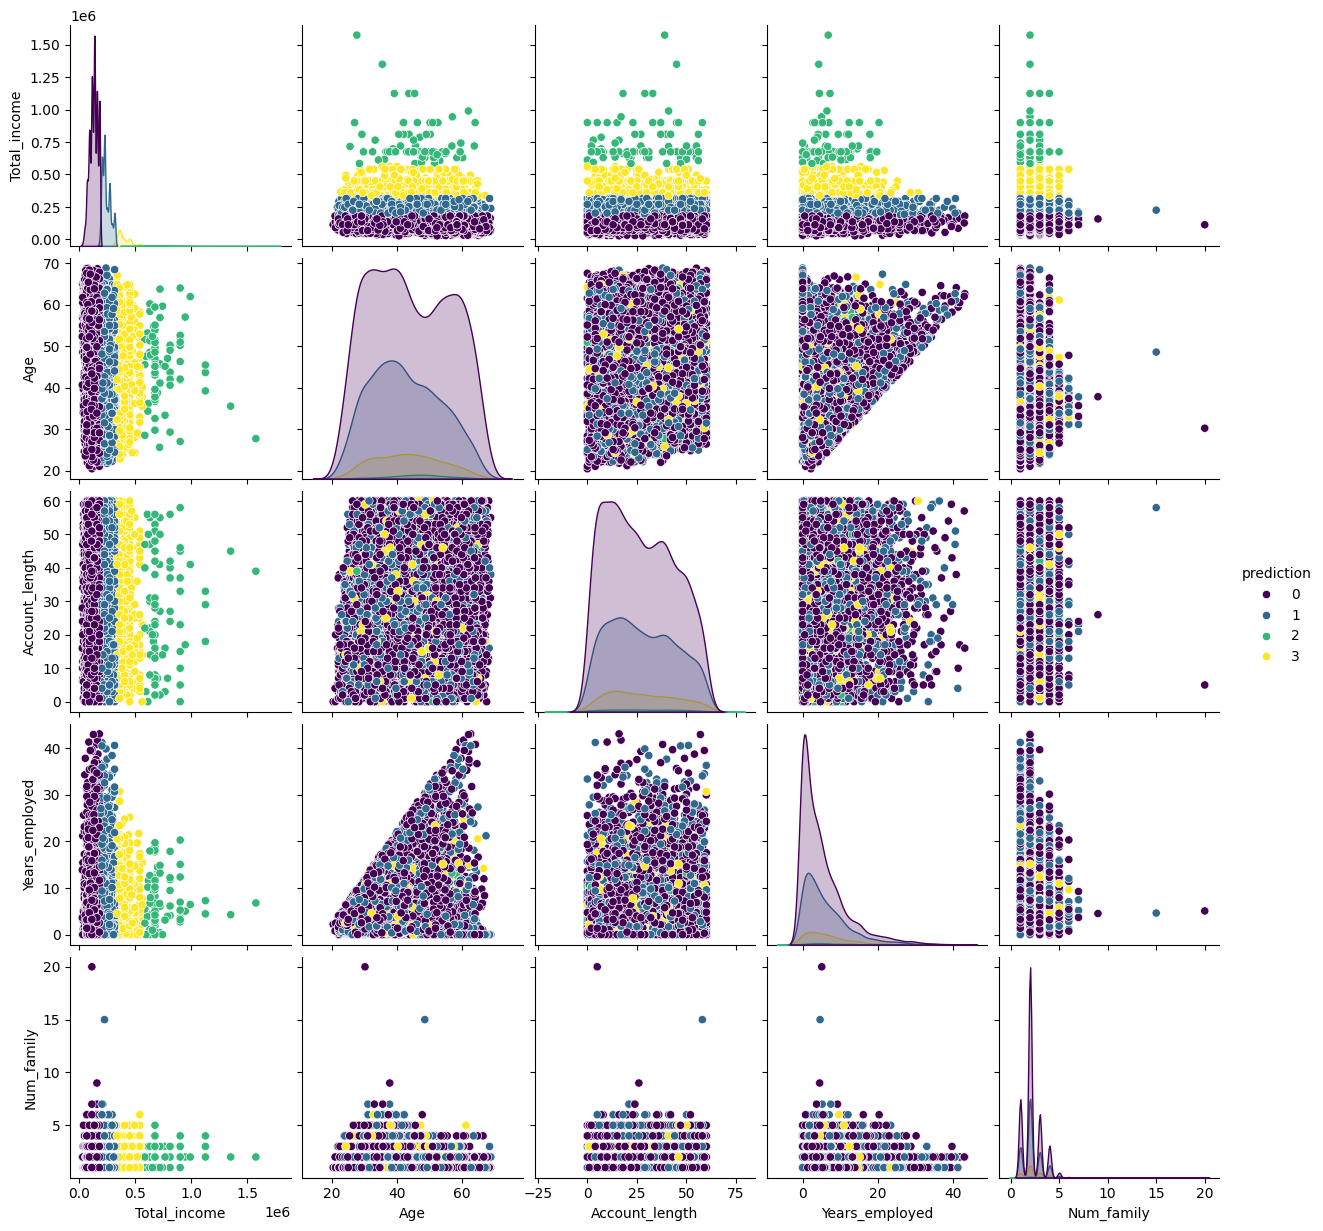

In [34]:
# Specify the features for the pair plot
pairplot_features = ["Total_income", "Age", "Account_length", "Years_employed", "Num_family"]

# Add 'prediction' column to visualize clusters
pairplot_features.append("prediction")

# Create a pair plot using seaborn for visualisation
sns.pairplot(clusters_pd[pairplot_features], hue="prediction", palette="viridis")
plt.show()

K_nearest neighbors classifier modelling

In [35]:
# Prepare the data for KNeighborsClassifier predictions
X = modelling_df[["Total_income", "Age", "Account_length", "Years_employed", "Num_family"]]
y = modelling_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# List to store accuracy scores
accuracy_scores = []

In [37]:
# Range of n_neighbors to test
neighbor_range = range(1, 10)

In [38]:
# Loop through different values of n_neighbors
for n_neighbors in neighbor_range:
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy)

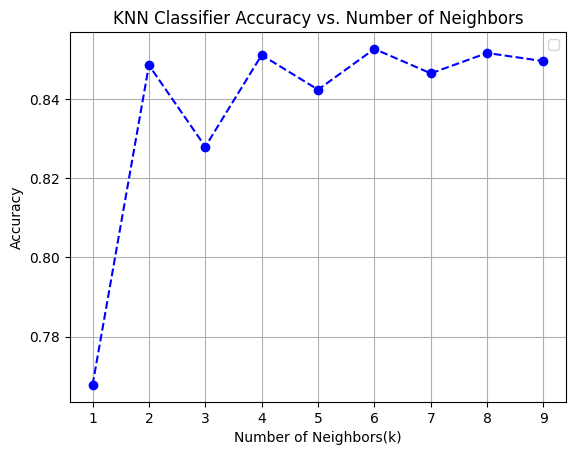

In [39]:
# Plotting the accuracy scores
plt.plot(neighbor_range, accuracy_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Neighbors(k)')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy vs. Number of Neighbors')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [40]:
# Initialize and train the KNN classifier using the best k=6
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of KNN model: {accuracy:.3f}')

# Perform 5-fold cross-validation
cv_scores = cross_val_score(knn, X, y, cv=5)

# Print cross-validation scores and their mean
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean():.3f}')

Accuracy of KNN model: 0.853
Cross-validation scores: [0.8661174  0.86302781 0.8661174  0.86714727 0.86295724]
Mean cross-validation accuracy: 0.865


**Findings from Kmeans visualisation and KNN prediction**:

In [41]:
# Generate a DataFrame for all the models "Random_Forest", "Nand their accuracy for comparisons
Model = ["Random_Forest","Neural_Network_ReLu", "Neural_Network_Tanh", "Deep_Learning","K_nearest_Neighbors"]
Accuracy = [0.857, 0.868, 0.868, 0.865, 0.853]
df_model_performance = pd.DataFrame({"Model": Model, "Accuracy": Accuracy})
df_model_performance

,Model,Accuracy
0,Random_Forest,0.857
1,Neural_Network_ReLu,0.868
2,Neural_Network_Tanh,0.868
3,Deep_Learning,0.865
4,K_nearest_Neighbors,0.853


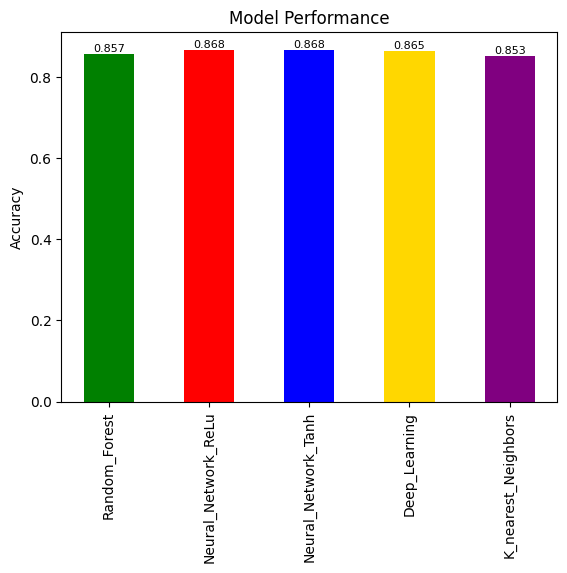

In [42]:
# Plot the model performance
bar_labels = Model
bar_colors = ["green","red", "blue", "gold","purple"]
bar_container_performance = plt.bar(Model, Accuracy, color=bar_colors, width=0.5, linestyle='--')
plt.xticks(rotation="vertical")
plt.bar_label(bar_container_performance, fontsize=8)
plt.title("Model Performance")
plt.ylabel("Accuracy")
plt.bar(df_model_performance["Model"], df_model_performance["Accuracy"], color=bar_colors, width=0.5, linestyle='--')
plt.show()


Summary: The best prediction model appears to be the simplest neural network model with one input layer and one output layer.